In [1]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from itertools import product

/home/cris/anaconda3/lib/python3.8/site-packages/qiskit/optimization/__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


In [2]:
#  Here I construct my network or graph, indicating the number of nodes (n) and the weight of
# the conexions between nodes (edges), with each term corresponding to (node,weight)=(i,j,w_ij)
G = nx.Graph()
n = 5
G.add_nodes_from(range(n))
edges = [(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(4,2,1.0),(0,3,1.0)] 
G.add_weighted_edges_from(edges)

#  Here I construct the matrix of weights and the matrix of binary states
w = np.zeros([n,n])
edgs = np.array(edges)

for u in range(edgs.shape[0]):
    i0, j0, wij0 = edgs[u]
    i = int(i0)
    j = int(j0)
    wij = int(wij0)
    w[i,j] = wij
    w[j,i] = wij
    
lst1 = [list(i) for i in product([0, 1], repeat=n)]
lst = np.array(lst1)
print('Weight matrix:')
print(w)
print('Possible binary states, being 0 one of the subsets and 1 the other:')
print(lst)

Weight matrix:
[[0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1.]
 [1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
Possible binary states, being 0 one of the subsets and 1 the other:
[[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 1]
 [0 0 1 0 0]
 [0 0 1 0 1]
 [0 0 1 1 0]
 [0 0 1 1 1]
 [0 1 0 0 0]
 [0 1 0 0 1]
 [0 1 0 1 0]
 [0 1 0 1 1]
 [0 1 1 0 0]
 [0 1 1 0 1]
 [0 1 1 1 0]
 [0 1 1 1 1]
 [1 0 0 0 0]
 [1 0 0 0 1]
 [1 0 0 1 0]
 [1 0 0 1 1]
 [1 0 1 0 0]
 [1 0 1 0 1]
 [1 0 1 1 0]
 [1 0 1 1 1]
 [1 1 0 0 0]
 [1 1 0 0 1]
 [1 1 0 1 0]
 [1 1 0 1 1]
 [1 1 1 0 0]
 [1 1 1 0 1]
 [1 1 1 1 0]
 [1 1 1 1 1]]


In [3]:
# Brute force calculation
best = 0
for case in range(2**n):
    cost = 0
    cost = cost + max_cut.max_cut_value(lst[case],w)
    #print(str(lst[case]) + str(cost))
    if cost > best:
        best = cost
        lstbest = lst[case]
        
print('Best solution = ' + str(lstbest) + str(best))

Best solution = [0 1 0 1 1]5.0


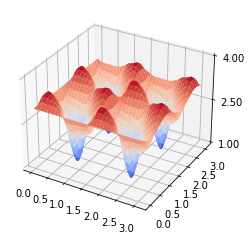


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [4]:
#  This part is to search for the optimum parameters gamma and beta 
# (directly copy-pasted from https://qiskit.org/textbook/ch-applications/qaoa.html#approximateOPT)

# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

In [5]:
#  Here I construct my qc circuit, with n qubits for the quantum circuit and n bits to store the 
# results of the measurements.
#  A QAOA circuit consists of a series of Hadamard gates (obtaining all the possible binary states),
# Ising phase gates with angle gamma at each node with weighted links, and X rotation gates with angle beta.
#  Finally, we measure.
qc = QuantumCircuit(n,n)

qc.h(range(n))
qc.barrier()

for edge in edges:
    i = edge[0]
    j = edge[1]
    qc.cp(-2*gamma, i, j)
    qc.p(gamma, i)
    qc.p(gamma, j)
    qc.barrier()
    
qc.barrier()
qc.rx(2*beta, range(n))

qc.barrier()
qc.measure(range(n),range(n))

qc.draw()

┌───┐ ░           ┌────────┐ ░           ┌────────┐ ░                     »
q_0: ┤ H ├─░──■────────┤ P(1.9) ├─░──■────────┤ P(1.9) ├─░─────────────────────»
     ├───┤ ░  │P(-3.8) ├────────┤ ░  │        └────────┘ ░           ┌────────┐»
q_1: ┤ H ├─░──■────────┤ P(1.9) ├─░──┼───────────────────░──■────────┤ P(1.9) ├»
     ├───┤ ░           └────────┘ ░  │P(-3.8) ┌────────┐ ░  │P(-3.8) ├────────┤»
q_2: ┤ H ├─░──────────────────────░──■────────┤ P(1.9) ├─░──■────────┤ P(1.9) ├»
     ├───┤ ░                      ░           └────────┘ ░           └────────┘»
q_3: ┤ H ├─░──────────────────────░──────────────────────░─────────────────────»
     ├───┤ ░                      ░                      ░                     »
q_4: ┤ H ├─░──────────────────────░──────────────────────░─────────────────────»
     └───┘ ░                      ░                      ░                     »
c: 5/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«      ░                      ░                      ░           ┌────────┐ ░ »
«q_0: ─░──────────────────────░──────────────────────░──■────────┤ P(1.9) ├─░─»
«      ░                      ░                      ░  │        └────────┘ ░ »
«q_1: ─░──────────────────────░──────────────────────░──┼───────────────────░─»
«      ░           ┌────────┐ ░           ┌────────┐ ░  │                   ░ »
«q_2: ─░──■────────┤ P(1.9) ├─░──■────────┤ P(1.9) ├─░──┼───────────────────░─»
«      ░  │P(-3.8) ├────────┤ ░  │        └────────┘ ░  │P(-3.8) ┌────────┐ ░ »
«q_3: ─░──■────────┤ P(1.9) ├─░──┼───────────────────░──■────────┤ P(1.9) ├─░─»
«      ░           └────────┘ ░  │P(-3.8) ┌────────┐ ░           └────────┘ ░ »
«q_4: ─░──────────────────────░──■────────┤ P(1.9) ├─░──────────────────────░─»
«      ░                      ░           └────────┘ ░                      ░ »
«c: 5/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«      ░ ┌─────────┐ ░ ┌─┐            
«q_0: ─░─┤ RX(0.4) ├─░─┤M├────────────
«      ░ ├─────────┤ ░ └╥┘┌─┐         
«q_1: ─░─┤ RX(0.4) ├─░──╫─┤M├─────────
«      ░ ├─────────┤ ░  ║ └╥┘┌─┐      
«q_2: ─░─┤ RX(0.4) ├─░──╫──╫─┤M├──────
«      ░ ├─────────┤ ░  ║  ║ └╥┘┌─┐   
«q_3: ─░─┤ RX(0.4) ├─░──╫──╫──╫─┤M├───
«      ░ ├─────────┤ ░  ║  ║  ║ └╥┘┌─┐
«q_4: ─░─┤ RX(0.4) ├─░──╫──╫──╫──╫─┤M├
«      ░ └─────────┘ ░  ║  ║  ║  ║ └╥┘
«c: 5/══════════════════╩══╩══╩══╩══╩═
«                       0  1  2  3  4

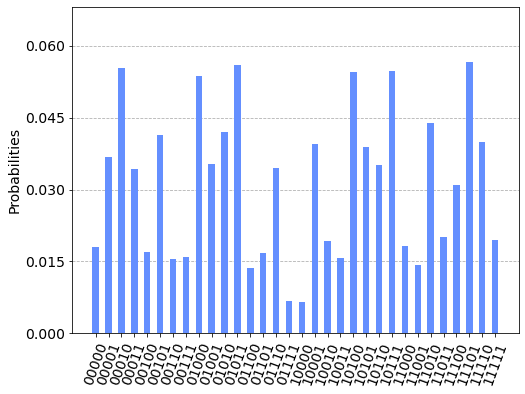

In [6]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")
shots = 10000

Tqc = transpile(qc, backend)
qobj = assemble(Tqc, shots=shots)
qc_results = backend.run(qobj).result()

plot_histogram(qc_results.get_counts(),figsize = (8,6),bar_labels = False)


In [8]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

{'01111': 68, '00110': 154, '11100': 309, '11110': 400, '11001': 142, '11011': 200, '01100': 136, '00010': 553, '10011': 158, '01101': 167, '00001': 368, '10000': 66, '10101': 388, '00100': 170, '00011': 342, '00111': 160, '01110': 344, '01010': 420, '10001': 394, '11101': 567, '10100': 545, '01001': 353, '00101': 413, '11000': 182, '10111': 547, '11010': 439, '00000': 181, '01011': 560, '10110': 351, '10010': 192, '11111': 194, '01000': 537}
------------------------------------------------
dict_keys(['01111', '00110', '11100', '11110', '11001', '11011', '01100', '00010', '10011', '01101', '00001', '10000', '10101', '00100', '00011', '00111', '01110', '01010', '10001', '11101', '10100', '01001', '00101', '11000', '10111', '11010', '00000', '01011', '10110', '10010', '11111', '01000'])
------------------------------------------------

 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 2.99 while the true value is M1 = 3.43 

The approximate solution is x* = 10100 with C

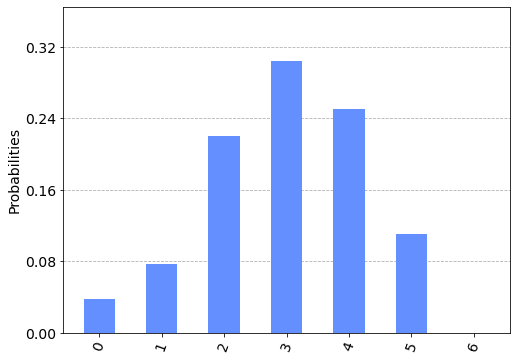

In [9]:
counts = qc_results.get_counts()
print(counts)
print('''------------------------------------------------''')
print(counts.keys())
print('''------------------------------------------------''')

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)